In [2]:
import os
os.getcwd()

'/Users/moniquecavalcanti/Documents/POLI/TCC/release_in_the_wild'

In [1]:
print("oi")

oi


In [3]:
os.listdir()

['.DS_Store',
 'teste keras cnn mfcc.ipynb',
 'real',
 '.ipynb_checkpoints',
 'keras auc.py',
 'deepfake_audio_model_cnn_mfcc.keras',
 'fake']

In [4]:
REAL_DIR = os.path.join("real")
FAKE_DIR = os.path.join("fake")
os.path.exists(REAL_DIR), os.path.exists(FAKE_DIR)


(True, True)

In [8]:
# ======================================================
# 1. Importações
# ======================================================
import os
import numpy as np
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import load_model
import time

# ======================================================
# 3. Caminhos do Dataset e Modelo
# ======================================================
DATASET_DIR = ''
REAL_DIR = os.path.join(DATASET_DIR, "real")
FAKE_DIR = os.path.join(DATASET_DIR, "fake")

MODEL_PATH = "deepfake_audio_model_cnn_mfcc.keras"

SAMPLE_RATE = 16000
N_MFCC = 40
FIXED_FRAMES = 128

# ======================================================
# 4. Funções auxiliares
# ======================================================
def extract_mfcc(wav, sr=SAMPLE_RATE, n_mfcc=N_MFCC, max_len=FIXED_FRAMES):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)

    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

def load_audio(path):
    wav, sr = sf.read(path)
    if wav.ndim > 1:
        wav = wav.mean(axis=1)
    if sr != SAMPLE_RATE:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=sr, target_sr=SAMPLE_RATE)
    return wav.astype(np.float32)

def count_audio_files(root_dir):
    total = 0
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith((".wav", ".flac", ".mp3")):
                total += 1
    return total

def load_dataset(real_dir, fake_dir):

    # ------ CONTAR TOTAL DE ÁUDIOS ------
    total_real = count_audio_files(real_dir)
    total_fake = count_audio_files(fake_dir)
    total_files = total_real + total_fake

    print(f"Total de áudios encontrados: {total_files} (Real: {total_real}, Fake: {total_fake})")

    X, y, persons = [], [], []
    loaded = 0  # contador

    # =============== REAL ===============
    for person in os.listdir(real_dir):
        person_path = os.path.join(real_dir, person)
        if os.path.isdir(person_path):
            for root, _, files in os.walk(person_path):
                for f in files:
                    if f.lower().endswith((".wav", ".flac", ".mp3")):
                        path = os.path.join(root, f)

                        wav = load_audio(path)
                        X.append(extract_mfcc(wav))
                        y.append(0)
                        persons.append(person)

                        loaded += 1
                        perc = (loaded / total_files) * 100
                        print(f"\rCarregando dataset... {perc:.2f}% ({loaded}/{total_files})", end="")

    # =============== FAKE ===============
    for person in os.listdir(fake_dir):
        person_path = os.path.join(fake_dir, person)
        if os.path.isdir(person_path):
            for root, _, files in os.walk(person_path):
                for f in files:
                    if f.lower().endswith((".wav", ".flac", ".mp3")):
                        path = os.path.join(root, f)

                        wav = load_audio(path)
                        X.append(extract_mfcc(wav))
                        y.append(1)
                        persons.append(person)

                        loaded += 1
                        perc = (loaded / total_files) * 100
                        print(f"\rCarregando dataset... {perc:.2f}% ({loaded}/{total_files})", end="")

    print("\n")  # nova linha após completar

    X = np.array(X)[..., np.newaxis]
    y = np.array(y)
    persons = np.array(persons)
    return X, y, persons


# ======================================================
# 5. Carregar Dataset (COM TEMPO)
# ======================================================
print("Carregando dataset...")
start_time = time.time()

X, y, persons = load_dataset(REAL_DIR, FAKE_DIR)

elapsed = time.time() - start_time
print(f"\nDataset carregado em {elapsed:.2f} segundos")

print("Shape:", X.shape, y.shape)
print("Pessoas únicas:", len(np.unique(persons)))


# ======================================================
# 6. Dividir Teste (igual ao treinamento original)
# ======================================================
unique_persons = np.unique(persons)

train_persons, test_persons = train_test_split(
    unique_persons, test_size=0.2, random_state=42
)

test_mask = np.isin(persons, test_persons)

X_test = X[test_mask]
y_test = y[test_mask]

print("Teste:", X_test.shape, y_test.shape)


# ======================================================
# 7. Carregar modelo Keras
# ======================================================
print("Carregando modelo...")
model = load_model(MODEL_PATH)
print("Modelo carregado!")


# ======================================================
# 8. Avaliação
# ======================================================
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int).flatten()

print("\n====== CLASSIFICATION REPORT ======")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"], zero_division=0))

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\n====== CONFUSION MATRIX ======")
print(confusion_matrix(y_test, y_pred))


Carregando dataset...
Total de áudios encontrados: 36975 (Real: 19999, Fake: 16976)
Carregando dataset... 100.00% (36975/36975)


Dataset carregado em 455.95 segundos
Shape: (36975, 40, 128, 1) (36975,)
Pessoas únicas: 40
Teste: (7182, 40, 128, 1) (7182,)
Carregando modelo...
Modelo carregado!
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step

====== CLASSIFICATION REPORT ======
              precision    recall  f1-score   support

        Real       0.85      0.99      0.92      4000
        Fake       0.99      0.78      0.87      3182

    accuracy                           0.90      7182
   macro avg       0.92      0.89      0.89      7182
weighted avg       0.91      0.90      0.90      7182

Accuracy: 0.8994708994708994

====== CONFUSION MATRIX ======
[[3976   24]
 [ 698 2484]]


In [19]:
print("oi")

oi


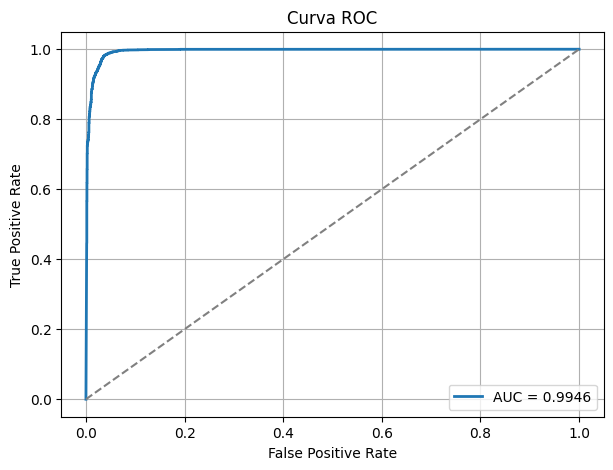

AUC (Área sob a Curva ROC): 0.9946


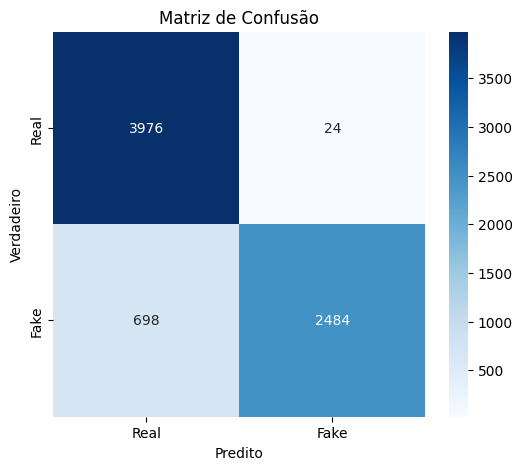

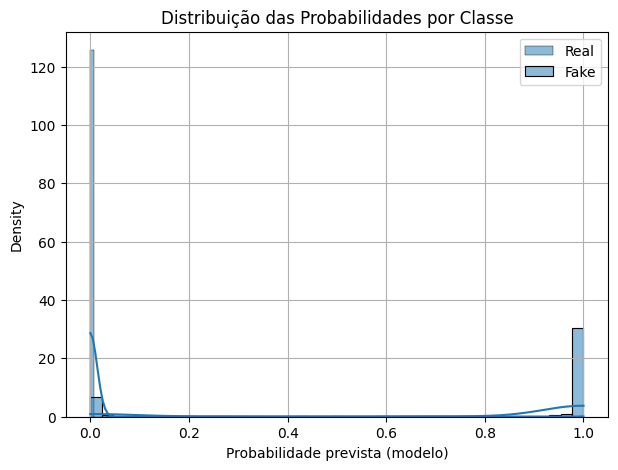

===== MÉTRICAS COMPLEMENTARES =====
Precisão (Precision): 0.9904
Recall (Sensibilidade): 0.7806
F1-Score: 0.8731
MAE das Probabilidades: 0.1014

===== DESEMPENHO DO MODELO =====
Tempo médio por amostra: 0.517 ms
Amostras por segundo (FPS): 1936.10


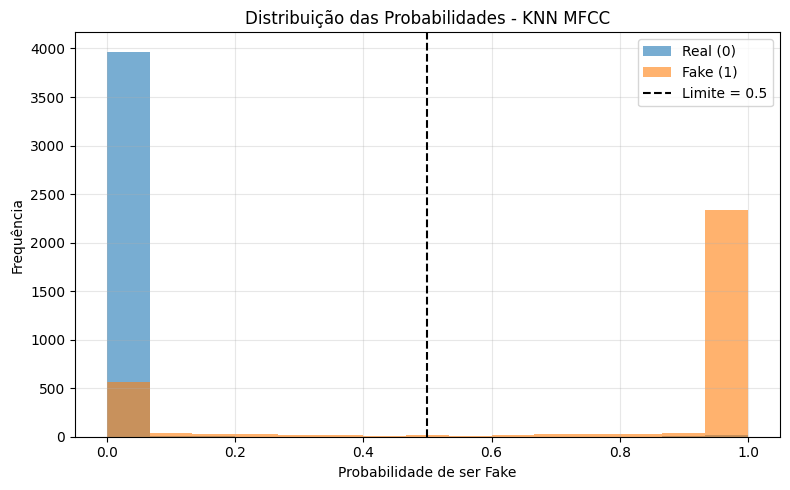

In [9]:
# =====================================================
# 9. Relatórios Avançados e Gráficos para o TCC
# ======================================================
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np
import time

# ====== 1. Curva ROC ======
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC (Área sob a Curva ROC): {roc_auc:.4f}")


# ====== 2. Matriz de Confusão ======
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


# ====== 3. Distribuição das probabilidades ======
plt.figure(figsize=(7, 5))
sns.histplot(y_prob[y_test == 0], label="Real", kde=True, stat="density")
sns.histplot(y_prob[y_test == 1], label="Fake", kde=True, stat="density")
plt.title("Distribuição das Probabilidades por Classe")
plt.xlabel("Probabilidade prevista (modelo)")
plt.legend()
plt.grid(True)
plt.show()


# ====== 4. Precisão, Recall, F1 ======
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error

precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
mae       = mean_absolute_error(y_test, y_prob)

print("===== MÉTRICAS COMPLEMENTARES =====")
print(f"Precisão (Precision): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MAE das Probabilidades: {mae:.4f}")


# ====== 5. Tempo de inferência ======
start = time.time()
_ = model.predict(X_test, verbose=0)
end = time.time()

avg_time = (end - start) / len(X_test)
fps = 1 / avg_time

print("\n===== DESEMPENHO DO MODELO =====")
print(f"Tempo médio por amostra: {avg_time*1000:.3f} ms")
print(f"Amostras por segundo (FPS): {fps:.2f}")

# ====== 6. Gráfico de comparação Verdadeiro vs Predito ======
plt.figure(figsize=(8,5))
plt.hist(y_prob[y_test == 0], bins=15, alpha=0.6, label="Real (0)")
plt.hist(y_prob[y_test == 1], bins=15, alpha=0.6, label="Fake (1)")
plt.axvline(0.5, color="k", linestyle="--", label="Limite = 0.5")

plt.title("Distribuição das Probabilidades - KNN MFCC")
plt.xlabel("Probabilidade de ser Fake")
plt.ylabel("Frequência")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

